In [2]:
import os
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.nn as nn
import torchvision.models as models
from sklearn.model_selection import train_test_split
import numpy as np

class CustomDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.dataframe.iloc[idx, 0])
        image = Image.open(img_name)
        
        # Assuming the labels are in columns 1 and 2 and are categorical (e.g., 'Positive', 'Negative')
        label1 = 1 if self.dataframe.iloc[idx, 1] == 'Positive' else 0
        label2 = 1 if self.dataframe.iloc[idx, 2] == 'Positive' else 0
        labels = np.array([label1, label2], dtype=np.float32)
        
        if self.transform:
            image = self.transform(image)

        return image, labels
        


# Transformations for the image
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

# Load CSV
dataframe = pd.read_csv('combined_task_data6.csv')

# Splitting dataset
train_val_data, test_data = train_test_split(dataframe, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_val_data, test_size=0.1, random_state=42)

# Initialize datasets
train_dataset = CustomDataset(train_data, root_dir='/Users/VanKhai/Desktop/TCGA_BRCA_Histology/', transform=train_transform)
val_dataset = CustomDataset(val_data, root_dir='/Users/VanKhai/Desktop/TCGA_BRCA_Histology/', transform=test_transform)
test_dataset = CustomDataset(test_data, root_dir='/Users/VanKhai/Desktop/TCGA_BRCA_Histology/', transform=test_transform)

# DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [3]:
from torch.optim import Adam

class SoftParameterSharingModel(nn.Module):
    def __init__(self):
        super(SoftParameterSharingModel, self).__init__()
        
        self.model1 = models.resnet50(pretrained=True)
        self.model1.fc = nn.Sequential(
            nn.Linear(self.model1.fc.in_features, 1),
            nn.Sigmoid()  
        )
        
        self.model2 = models.resnet50(pretrained=True)
        self.model2.fc = nn.Sequential(
            nn.Linear(self.model2.fc.in_features, 1),
            nn.Sigmoid() 
        )

    def forward(self, x):
        out1 = self.model1(x)
        out2 = self.model2(x)
        return out1, out2

def compute_soft_sharing_loss(model, lambda_reg=0.01):
    reg_loss = 0.0
    for param1, param2 in zip(model.model1.parameters(), model.model2.parameters()):
        reg_loss += torch.norm(param1 - param2, p=2)
    return lambda_reg * reg_loss

# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SoftParameterSharingModel().to(device)

# Loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = Adam(model.parameters(), lr=0.001)

/Users/VanKhai/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/VanKhai/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
# Example training loop
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    for images, labels in train_dataloader:
        labels = labels.to(device)
        inputs = images.to(device)
        optimizer.zero_grad()
        outputs1, outputs2 = model(inputs)
        loss1 = criterion(outputs1.squeeze(), labels[:, 0])
        loss2 = criterion(outputs2.squeeze(), labels[:, 1])
        # Compute the regularization term
        reg_loss = compute_soft_sharing_loss(model)
        # Total loss is the sum of task-specific losses and the regularization term
        loss = loss1 + loss2 + reg_loss
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * inputs.size(0)
    print(f'Epoch {epoch+1}, Loss: {total_loss / len(train_dataset):.4f}')

Epoch 1, Loss: 0.6795
Epoch 2, Loss: 0.3373
Epoch 3, Loss: 0.2730
Epoch 4, Loss: 0.2484
Epoch 5, Loss: 0.2308


In [6]:
from sklearn.metrics import roc_auc_score
def evaluate_model(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0.0
    total_accuracy1 = 0.0
    total_accuracy2 = 0.0
    total_samples = 0

    all_labels1 = []
    all_predictions1 = []
    all_labels2 = []
    all_predictions2 = []

    with torch.no_grad():
        for images, labels in dataloader:
            labels = labels.to(device)
            inputs = images.to(device)
            outputs1, outputs2 = model(inputs)

            outputs1 = outputs1.squeeze()
            outputs2 = outputs2.squeeze()

            if outputs1.ndim == 0:
                outputs1 = outputs1.unsqueeze(0)
            if outputs2.ndim == 0:
                outputs2 = outputs2.unsqueeze(0)

            loss1 = criterion(outputs1, labels[:, 0])
            loss2 = criterion(outputs2, labels[:, 1])
            loss = loss1 + loss2
            total_loss += loss.item() * inputs.size(0)

            preds1 = torch.sigmoid(outputs1) > 0.5
            preds2 = torch.sigmoid(outputs2) > 0.5
            correct1 = preds1 == labels[:, 0].bool()
            correct2 = preds2 == labels[:, 1].bool()

            total_accuracy1 += correct1.sum().item()
            total_accuracy2 += correct2.sum().item()
            total_samples += labels.size(0)

            all_labels1.extend(labels[:, 0].cpu().numpy())
            all_predictions1.extend(torch.sigmoid(outputs1).cpu().numpy())
            all_labels2.extend(labels[:, 1].cpu().numpy())
            all_predictions2.extend(torch.sigmoid(outputs2).cpu().numpy())

    avg_loss = total_loss / total_samples
    avg_accuracy1 = total_accuracy1 / total_samples
    avg_accuracy2 = total_accuracy2 / total_samples

    auc_score1 = None
    auc_score2 = None

    if len(np.unique(all_labels1)) > 1:
        auc_score1 = roc_auc_score(all_labels1, all_predictions1)
    if len(np.unique(all_labels2)) > 1:
        auc_score2 = roc_auc_score(all_labels2, all_predictions2)

    return avg_loss, avg_accuracy1, avg_accuracy2, auc_score1, auc_score2

# Evaluate on test data
test_loss, test_accuracy1, test_accuracy2, auc1, auc2 = evaluate_model(model, test_dataloader, criterion, device)
print(f'Test Loss: {test_loss:.4f}')
print(f'Accuracy for ER status: {test_accuracy1:.4f}, AUC: {auc1}')
print(f'Accuracy for HER2 status: {test_accuracy2:.4f}, AUC: {auc2}')


Test Loss: 0.2343
Accuracy for ER status: 0.9057, AUC: 0.9830041307168824
Accuracy for HER2 status: 1.0000, AUC: None


In [7]:
from sklearn.metrics import roc_auc_score
def evaluate_model(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0.0
    total_accuracy1 = 0.0
    total_accuracy2 = 0.0
    total_samples = 0

    all_labels1 = []
    all_predictions1 = []
    all_labels2 = []
    all_predictions2 = []

    with torch.no_grad():
        for images, labels in dataloader:
            labels = labels.to(device)
            inputs = images.to(device)
            outputs1, outputs2 = model(inputs)

            outputs1 = outputs1.squeeze()
            outputs2 = outputs2.squeeze()

            if outputs1.ndim == 0:
                outputs1 = outputs1.unsqueeze(0)
            if outputs2.ndim == 0:
                outputs2 = outputs2.unsqueeze(0)

            loss1 = criterion(outputs1, labels[:, 0])
            loss2 = criterion(outputs2, labels[:, 1])
            loss = loss1 + loss2
            total_loss += loss.item() * inputs.size(0)

            preds1 = torch.sigmoid(outputs1) > 0.5
            preds2 = torch.sigmoid(outputs2) > 0.5
            correct1 = preds1 == labels[:, 0].bool()
            correct2 = preds2 == labels[:, 1].bool()

            total_accuracy1 += correct1.sum().item()
            total_accuracy2 += correct2.sum().item()
            total_samples += labels.size(0)

            all_labels1.extend(labels[:, 0].cpu().numpy())
            all_predictions1.extend(torch.sigmoid(outputs1).cpu().numpy())
            all_labels2.extend(labels[:, 1].cpu().numpy())
            all_predictions2.extend(torch.sigmoid(outputs2).cpu().numpy())

    avg_loss = total_loss / total_samples
    avg_accuracy1 = total_accuracy1 / total_samples
    avg_accuracy2 = total_accuracy2 / total_samples

    auc_score1 = None
    auc_score2 = None

    if len(np.unique(all_labels1)) > 1:
        auc_score1 = roc_auc_score(all_labels1, all_predictions1)
    if len(np.unique(all_labels2)) > 1:
        auc_score2 = roc_auc_score(all_labels2, all_predictions2)

    return avg_loss, avg_accuracy1, avg_accuracy2, auc_score1, auc_score2

# Evaluate on test data
test_loss, test_accuracy1, test_accuracy2, auc1, auc2 = evaluate_model(model, test_dataloader, criterion, device)
print(f'Test Loss: {test_loss:.4f}')
print(f'Accuracy for ER status: {test_accuracy1:.4f}')
print(f'Accuracy for HER2 status: {test_accuracy2:.4f}')


Test Loss: 0.2343
Accuracy for ER status: 0.9057
Accuracy for HER2 status: 1.0000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Before normalization:


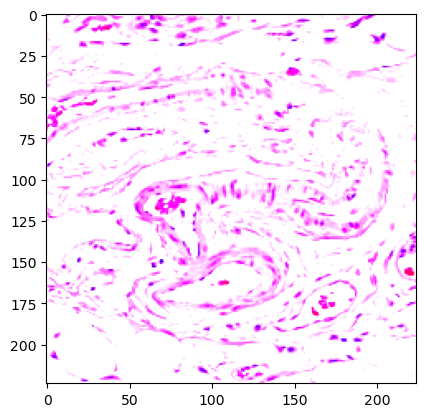

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


After normalization:


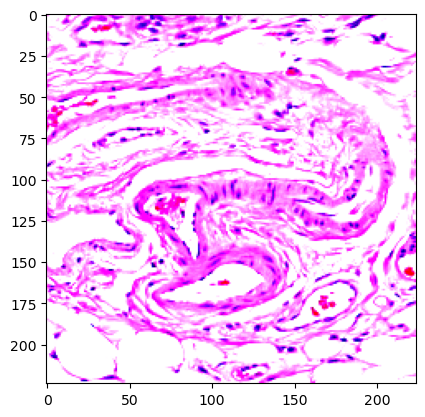

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Function to denormalize the image
def denormalize(tensor, mean, std):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

# Function to plot the image
def imshow(img, title=None):
    img = img.numpy().transpose((1, 2, 0))
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.show()

# Get a batch of training data
images, labels = next(iter(train_dataloader))

# Visualize one image before normalization
print("Before normalization:")
imshow(denormalize(images[5].clone(), mean=(0.485, 0.456, 0.406), std=(1, 1, 1)))

# Visualize one image after normalization
print("After normalization:")
imshow(images[5])

# Note: .clone() is used to avoid in-place modification of the original tensor
